In [32]:
import pandas as pd
import numpy as np

pixel_cols = [f'pixel{i}' for i in range(784)]

# Load Greek symbols
greek_df = pd.read_csv("greek_letters_inverted.csv")
greek_df['source'] = 'greek'
greek_df[pixel_cols] = greek_df[pixel_cols] / 255.0
greek_df['label'] = greek_df['label'].astype(str)

# Load Math operations
math_df = pd.read_csv("math_operations_inverted.csv")
math_df['source'] = 'math'
math_df[pixel_cols] = math_df[pixel_cols] / 255.0
math_df['label'] = math_df['label'].astype(str)

# Load EMNIST train/test
emnist_train = pd.read_csv("./data/EMNIST/emnist-byclass-train.csv", header=None)
emnist_test = pd.read_csv("./data/EMNIST/emnist-byclass-test.csv", header=None)

emnist_df = pd.concat([emnist_train, emnist_test], ignore_index=True)
emnist_df.columns = ['label'] + pixel_cols
emnist_df['source'] = 'emnist'
emnist_df[pixel_cols] = emnist_df[pixel_cols] / 255.0

# ✅ Map numeric labels to characters
mapping_df = pd.read_csv("./data/EMNIST/emnist-byclass-mapping.txt", sep=' ', header=None, names=['label_idx', 'ascii_code'])
mapping_dict = dict(zip(mapping_df['label_idx'], mapping_df['ascii_code'].map(chr)))
emnist_df['label'] = emnist_df['label'].astype(int).map(mapping_dict)

# Combine all datasets
combined_df = pd.concat([emnist_df, greek_df, math_df], ignore_index=True)

# ✅ Clean & filter
combined_df['label'] = combined_df['label'].astype(str).str.strip()
combined_df = combined_df[combined_df['label'] != '']
combined_df = combined_df.dropna(subset=['label'])

# ✅ Balance (optional)
balanced_df = combined_df.groupby('label').apply(lambda g: g.sample(n=min(len(g), 1000), random_state=42)).reset_index(drop=True)

# Preview
print("✅ Final dataset shape:", balanced_df.shape)
print("🧪 Unique labels:", sorted(balanced_df['label'].unique()))
print("🔢 Sources:", balanced_df['source'].value_counts())



/var/folders/bp/k3kx8znx5kz6y45zh5gv4gkc0000gn/T/ipykernel_3831/4158859544.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = combined_df.groupby('label').apply(lambda g: g.sample(n=min(len(g), 1000), random_state=42)).reset_index(drop=True)


✅ Final dataset shape: (62726, 787)
🧪 Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'alpha', 'b', 'beta', 'c', 'chi', 'd', 'delta', 'divide', 'e', 'epsilon', 'eta', 'f', 'g', 'gamma', 'h', 'i', 'integral', 'iota', 'j', 'k', 'kappa', 'l', 'lambda', 'm', 'minus', 'mu', 'n', 'nu', 'o', 'omega', 'omicron', 'p', 'phi', 'pi', 'plus', 'psi', 'q', 'r', 'rho', 's', 'sigma', 't', 'tau', 'theta', 'times', 'u', 'upsilon', 'v', 'w', 'x', 'xi', 'y', 'z', 'zeta']
🔢 Sources: source
emnist    62000
greek       600
math        126
Name: count, dtype: int64


In [33]:
import fitz  # PyMuPDF
import os

def convert_pdf_to_images(pdf_path, output_folder='./output/pages'):
    os.makedirs(output_folder, exist_ok=True)
    doc = fitz.open(pdf_path)
    image_paths = []
    for i in range(len(doc)):
        page = doc[i]
        pix = page.get_pixmap(dpi=300)
        img_path = os.path.join(output_folder, f"{os.path.basename(pdf_path).replace('.pdf','')}_page_{i}.png")
        pix.save(img_path)
        image_paths.append(img_path)
    return image_paths

# Run this for both PDFs
integral_page = convert_pdf_to_images("./data/integration.pdf", "./output/pages")
addition_page = convert_pdf_to_images("./data/addition.pdf", "./output/pages")
subtraction_page = convert_pdf_to_images("./data/subtraction.pdf", "./output/pages")
multiplication_page = convert_pdf_to_images("./data/multiplication.pdf", "./output/pages")
division_page = convert_pdf_to_images("./data/division.pdf", "./output/pages")


In [34]:
import cv2
import numpy as np

def extract_symbols_from_page(image_path, output_folder="./output/symbols", min_area=100):
    os.makedirs(output_folder, exist_ok=True)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Clean small noise
    kernel = np.ones((2,2), np.uint8)
    denoised = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(denoised, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > min_area:
            roi = denoised[y:y+h, x:x+w]
            resized = cv2.resize(roi, (28, 28))
            fname = f"{os.path.basename(image_path).replace('.png', '')}_sym{idx}.png"
            cv2.imwrite(os.path.join(output_folder, fname), resized)

for page in integral_page + addition_page + subtraction_page + multiplication_page + division_page:
    extract_symbols_from_page(page)

In [35]:
import os
import pandas as pd

def create_labels_csv(image_folder='./output/symbols', output_file='labels.csv'):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
    df = pd.DataFrame({'filename': image_files, 'label': [''] * len(image_files)})
    df.to_csv(output_file, index=False)
    print(f"{len(image_files)} entries written to {output_file}")

# Run this
create_labels_csv()

27 entries written to labels.csv


In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

# Columns and transform
pixel_cols = [f'pixel{i}' for i in range(784)]

# Data augmentation (jitter + rotate + affine)
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor()
])

# Custom dataset
class SymbolDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.labels = sorted(df['label'].unique())
        self.label_to_index = {label: idx for idx, label in enumerate(self.labels)}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = row[pixel_cols].values.reshape(28, 28).astype(np.uint8)  # use uint8 for PIL
        image = Image.fromarray(image)  # convert to PIL image first
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        label = self.label_to_index[row['label']]
        return image, label



In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['label'], random_state=42)

train_dataset = SymbolDataset(X_train, transform=transform)
test_dataset = SymbolDataset(X_test, transform=transforms.ToTensor())  # no augmentation

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [45]:
import torch.nn as nn
import torch.nn.functional as F

class SymbolCNN(nn.Module):
    def __init__(self, num_classes):
        super(SymbolCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SymbolCNN(num_classes=len(train_dataset.label_to_index)).to(device)


In [46]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, test_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")
    
    # Simple test accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"✅ Test Accuracy: {correct / total:.4f}")
    return model


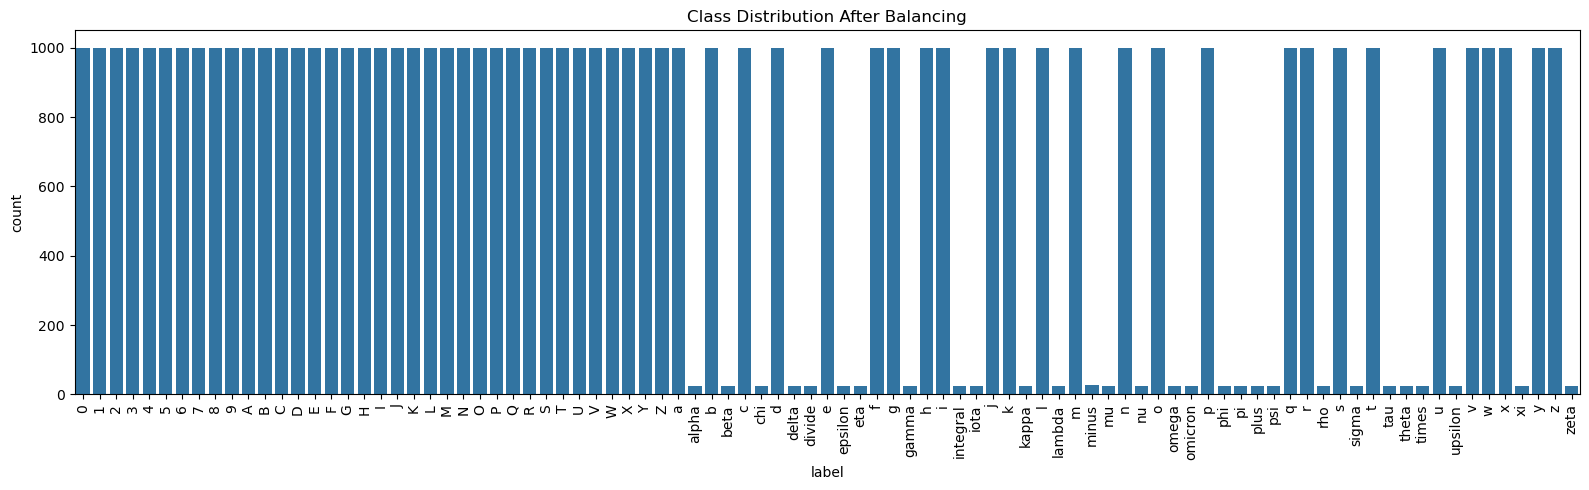

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
sns.countplot(data=balanced_df, x='label', order=sorted(balanced_df['label'].unique()))
plt.title("Class Distribution After Balancing")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [49]:
trained_model = train_model(model, train_loader, test_loader, epochs=10)


TypeError: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.

In [22]:
from PIL import Image
import torch
from torchvision import transforms

# Ensure model is in evaluation mode
trained_model.eval()

# Use same mapping from training dataset
label_mapping = dataset.index_to_label

# Define transform and rotate image upright
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

def predict_symbol(img_path):
    image = Image.open(img_path).convert("L").rotate(90, expand=True)
    image = transform(image).unsqueeze(0)  # add batch dim
    with torch.no_grad():
        output = trained_model(image)
        predicted_index = torch.argmax(output, dim=1).item()
    return label_mapping[predicted_index]



In [24]:
import os
from collections import defaultdict

symbol_dir = "./output/symbols"  # directory with cropped symbols
grouped_symbols = defaultdict(list)

# Group by filename prefix (e.g., addition_page_0)
for filename in os.listdir(symbol_dir):
    if filename.endswith(".png"):
        page = "_".join(filename.split("_")[:-1])
        grouped_symbols[page].append(filename)

# Sort symbols in correct order
def extract_symbol_index(filename):
    return int(filename.split("_sym")[-1].split(".")[0])


In [25]:
import sympy as sp

results = {}

for page, files in grouped_symbols.items():
    sorted_files = sorted(files, key=extract_symbol_index)
    raw_prediction = [predict_symbol(os.path.join(symbol_dir, f)) for f in sorted_files]

    expression = "".join(raw_prediction)

    # Replace symbolic characters with Python equivalents
    expression = (expression
        .replace("⋅", "*")
        .replace("π", "pi")
        .replace("∫", "integrate")
    )

    # Optional cleanup for double operators
    if expression.endswith("**"):
        expression = expression[:-1]
    expression = expression.replace("****", "**")

    try:
        if any(op in expression for op in ['integrate', 'pi', 'sin', 'cos']):
            x = sp.Symbol('x')
            result = eval("sp." + expression)
        else:
            result = eval(expression)
        results[page] = (expression, result)
    except Exception as e:
        results[page] = (expression, f"Error: {e}")


In [26]:
for page, (expr, value) in results.items():
    print(f"{page}: {expr} = {value}")


integration_page_0: xx**-**x* = Error: invalid syntax (<string>, line 1)
division_page_0: x**- = Error: invalid syntax (<string>, line 1)
multiplication_page_0: x*x = Error: name 'x' is not defined
subtraction_page_0: *** = Error: invalid syntax (<string>, line 1)
addition_page_0: x*0 = Error: name 'x' is not defined


In [27]:
import matplotlib.pyplot as plt

def debug_predict_image(img_path):
    image = Image.open(img_path).convert("L").rotate(90, expand=True)
    pred = predict_symbol(img_path)
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted: {pred}")
    plt.axis('off')
    plt.show()


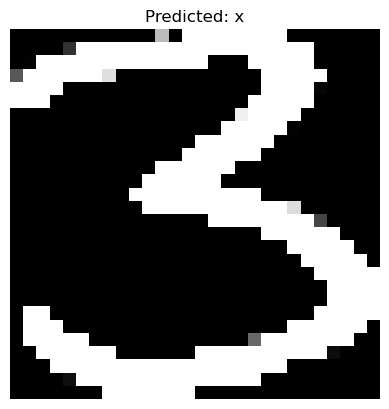

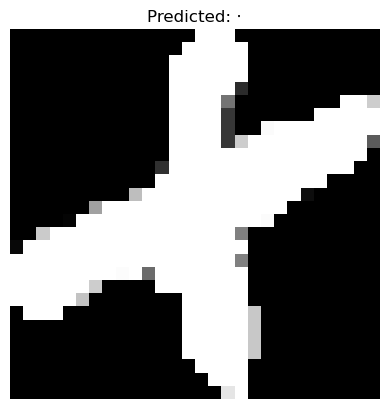

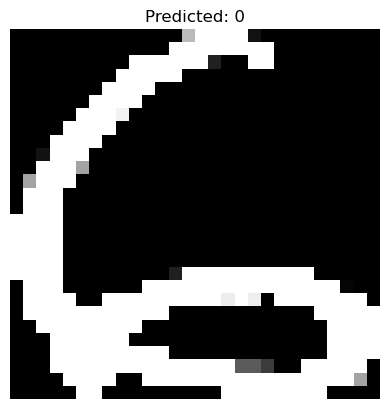

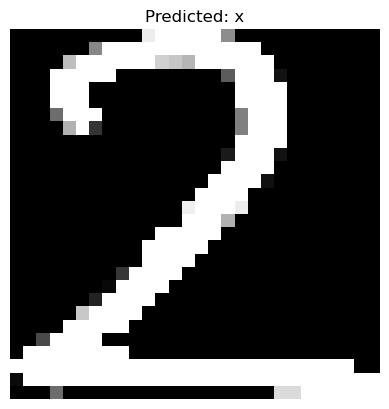

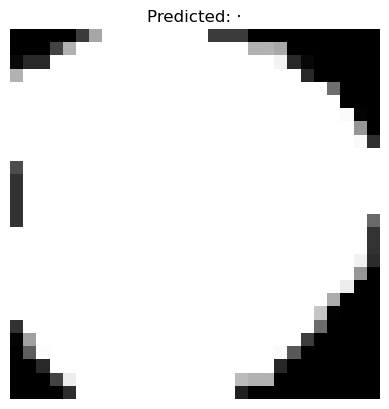

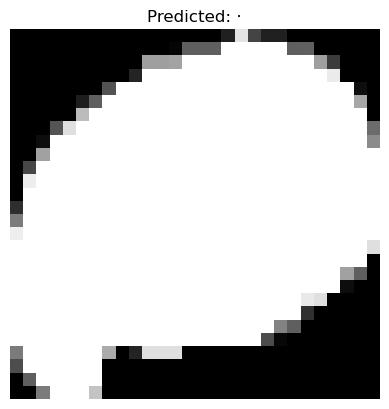

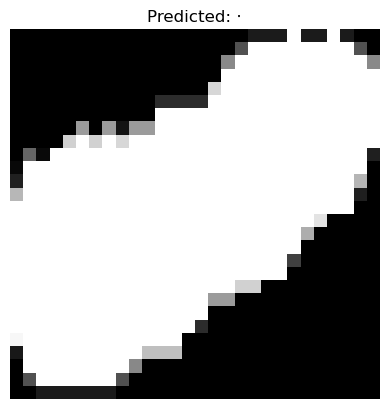

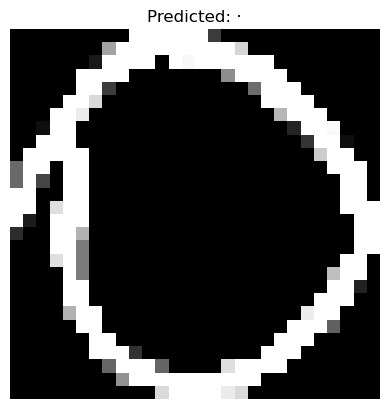

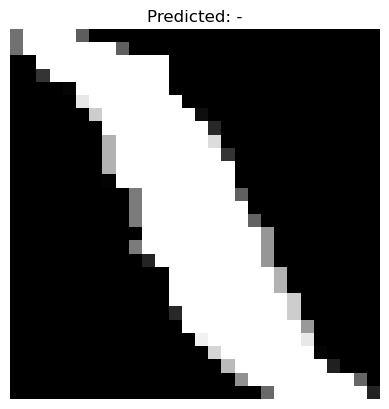

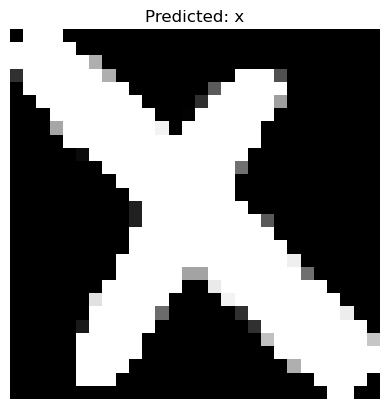

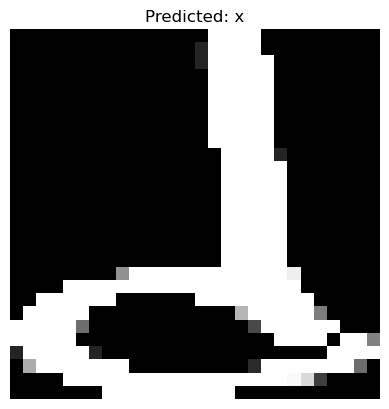

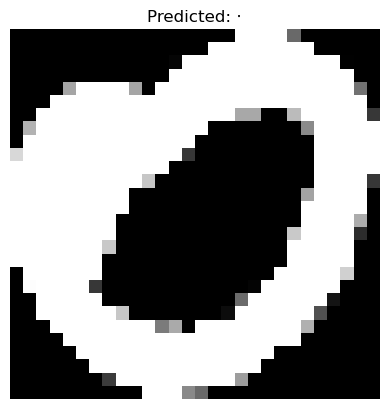

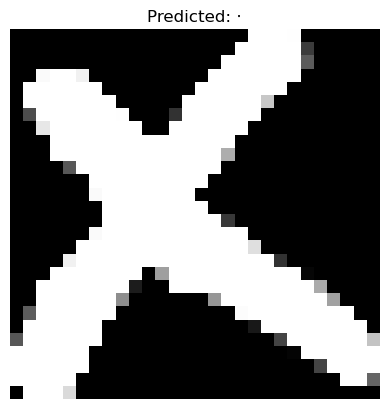

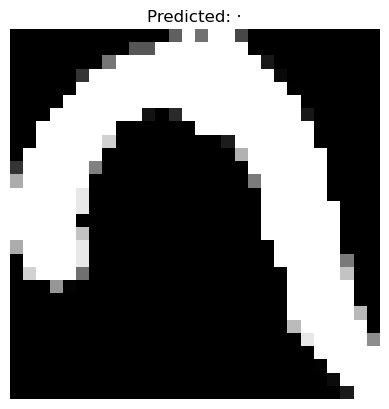

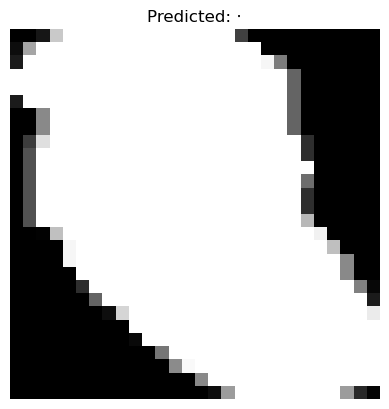

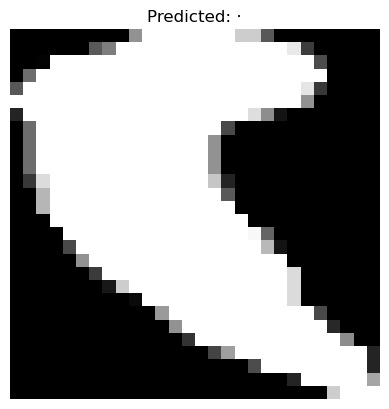

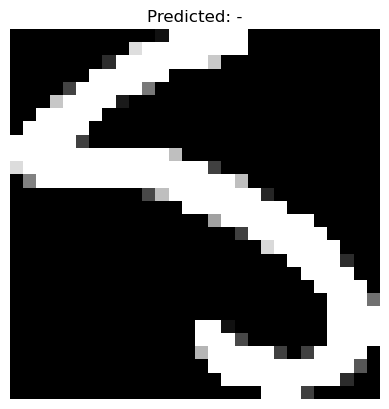

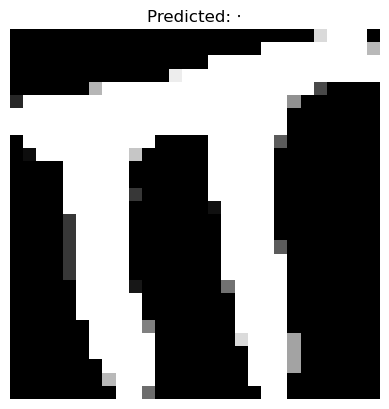

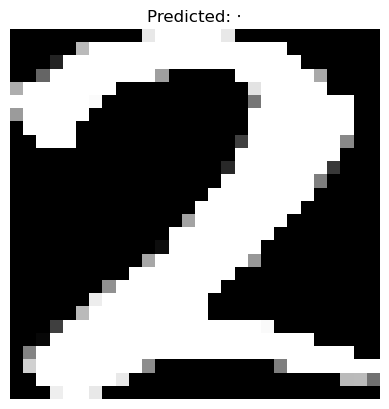

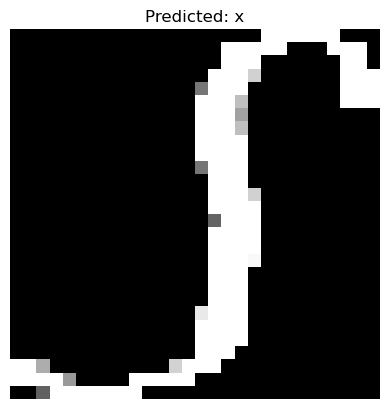

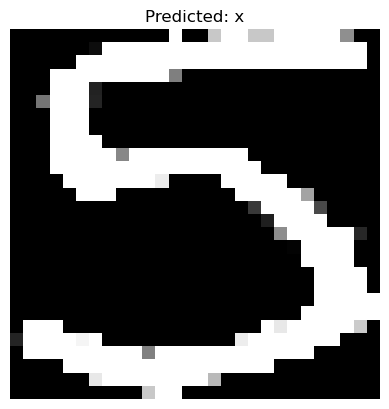

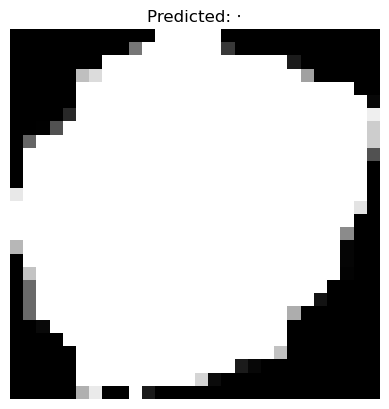

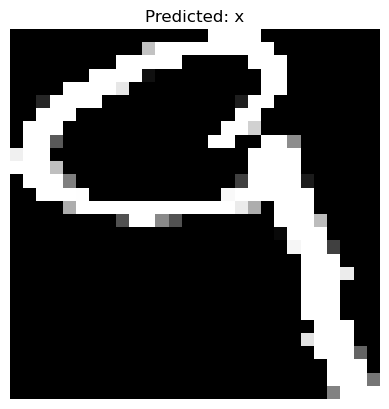

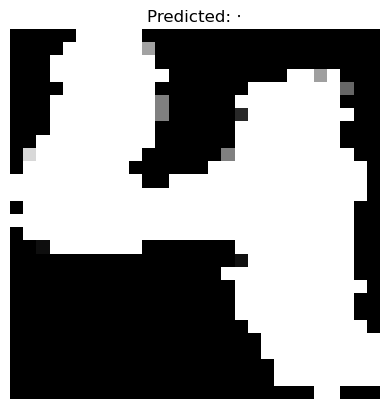

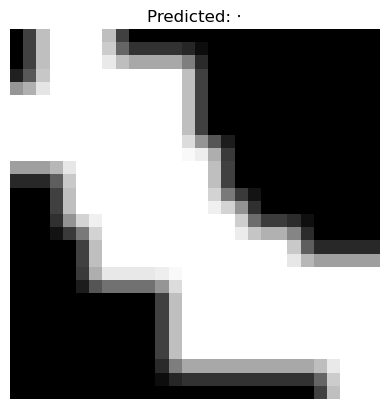

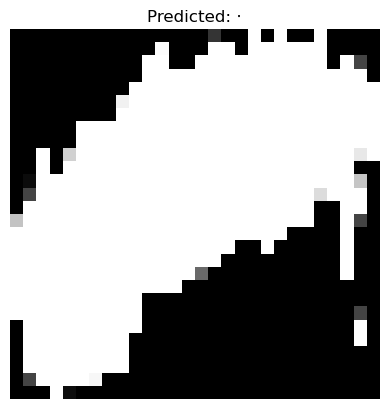

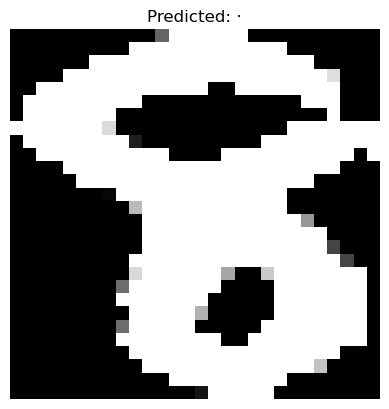

In [30]:
# Loop through all images in symbols folder
symbol_dir = "./output/symbols"  # adjust if needed

for filename in sorted(os.listdir(symbol_dir)):
    if filename.endswith(".png"):
        img_path = os.path.join(symbol_dir, filename)
        debug_predict_image(img_path)
